# Simulation Model

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import poisson

# Load and preprocessing  hospitalization data
hospitalization_df = pd.read_csv('/content/hospitalization.csv')
hospitalization_df['HOSP_ADMSN_TIME'] = pd.to_datetime(hospitalization_df['HOSP_ADMSN_TIME'], errors='coerce', format='%d%b%Y:%H:%M:%S')
hospitalization_df['END_DATE'] = pd.to_datetime(hospitalization_df['END_DATE'])
hospitalization_df['ADMISSION_DATE'] = hospitalization_df['HOSP_ADMSN_TIME'].dt.date

# Load and preprocessing ICU data
icu_df = pd.read_csv('/content/ICU.csv')
icu_df['DATE'] = pd.to_datetime(icu_df['DATE'], format='%d%b%Y')

# Calculate daily arrivals
daily_arrivals = hospitalization_df.groupby('ADMISSION_DATE').size()

# Merge data for ICU stay calculations
merged_df = pd.merge(icu_df, hospitalization_df[['PAT_ID', 'PAT_ENC_CSN_ID', 'END_DATE', 'severity']],
                     on=['PAT_ID', 'PAT_ENC_CSN_ID'])
merged_df['ICU_DATE'] = pd.to_datetime(merged_df['DATE'])
merged_df['ICU_STAY_LENGTH'] = (merged_df['END_DATE'] - merged_df['ICU_DATE']).dt.days

# Group by severity score into categories
merged_df['severity_group'] = pd.cut(merged_df['severity'], bins=[0, 0.33, 0.67, 1], labels=['Low', 'Medium', 'High'])
average_icu_stay_by_severity = merged_df.groupby('severity_group')['ICU_STAY_LENGTH'].mean()
daily_arrivals, average_icu_stay_by_severity

import numpy as np

# Calculate the 75th percentile of severity scores as the threshold for ICU admission
severity_threshold = hospitalization_df['severity'].quantile(0.75)

# Define the non-homogeneous Poisson process parameters
hospitalization_df['HOUR'] = hospitalization_df['HOSP_ADMSN_TIME'].dt.hour
hourly_arrivals = hospitalization_df.groupby('HOUR').size()

# Normalize hourly arrivals to get a rate per hour
days_in_data = (hospitalization_df['HOSP_ADMSN_TIME'].max() - hospitalization_df['HOSP_ADMSN_TIME'].min()).days + 1
hourly_rates = hourly_arrivals / days_in_data

severity_threshold, hourly_rates

print("severity threshold: ", severity_threshold)

# Ensure the 'DATE' in icu_df is datetime type for operations
icu_df['DATE'] = pd.to_datetime(icu_df['DATE'])

# Merge the ICU data with hospitalization data to get discharge dates
icu_with_discharge_dates = pd.merge(icu_df, hospitalization_df[['PAT_ID', 'PAT_ENC_CSN_ID', 'END_DATE']], on=['PAT_ID', 'PAT_ENC_CSN_ID'])

# Calculate the ICU stay duration in days
icu_with_discharge_dates['ICU_STAY_DURATION'] = (icu_with_discharge_dates['END_DATE'] - icu_with_discharge_dates['DATE']).dt.days

# Remove negative or zero durations
icu_stay_durations = icu_with_discharge_dates[icu_with_discharge_dates['ICU_STAY_DURATION'] > 0]
icu_stay_durations.describe()

# Constants
DAYS = 30  # Simulate for 30 days
ICU_CAPACITY = 32  # Number of ICU beds

# Sample hourly arrival rates
hourly_rates = np.mean(hourly_rates.values)

# Initialize counters
icu_admissions = 0
general_admissions = 0
icu_bed_occupancy = 0

# Simulate each day
for day in range(DAYS):
    # Simulate arrivals based on the average hourly rate over 24 hours
    daily_arrivals = np.random.poisson(hourly_rates * 24)

    # Process each arrival
    for _ in range(daily_arrivals):
        # Simulate severity score
        severity_score = np.random.uniform(0, 1)

        # Check for ICU admission
        if severity_score >= severity_threshold and icu_bed_occupancy < ICU_CAPACITY:
            icu_admissions += 1
            icu_bed_occupancy += 1
        else:
            general_admissions += 1

    discharges = min(icu_bed_occupancy, np.random.randint(1, 5))
    icu_bed_occupancy -= discharges

# Results
icu_admissions, general_admissions, icu_bed_occupancy

# Simulation function with policy parameter
def simulate_icu_policy(days, icu_capacity, policy):
    np.random.seed(42)  # Seed for reproducibility
    icu_admissions = 0
    general_admissions = 0
    icu_bed_occupancy = 0
    unmet_demand = 0  # Track demand that can't be met due to full ICU
    unadmitted_severe_patients = 0

    for day in range(days):
        daily_arrivals = np.random.poisson(hourly_rates * 24)

        for _ in range(daily_arrivals):
            severity_score = np.random.uniform(0, 1)

            if icu_bed_occupancy < icu_capacity:
                if policy == 'SST' and severity_score >= severity_threshold or policy == 'FCFS':
                    icu_admissions += 1
                    icu_bed_occupancy += 1
                else:
                    general_admissions += 1
            else:
                if severity_score >= severity_threshold:
                    unadmitted_severe_patients += 1  # Count as unadmitted from ICU but admitted to general wards
                general_admissions += 1  # All overflow to general ward

        discharges = min(icu_bed_occupancy, np.random.randint(1, 5))
        icu_bed_occupancy -= discharges

    return {
        'ICU Admissions': icu_admissions,
        'General Admissions': general_admissions,
        'End of Period ICU Occupancy': icu_bed_occupancy,
        'Unmet ICU Demand': unmet_demand,
        'Unadmitted Severe Patients': unadmitted_severe_patients
    }

# Run simulation for both policies
fcfs_results = simulate_icu_policy(DAYS, ICU_CAPACITY, 'FCFS')
sst_results = simulate_icu_policy(DAYS, ICU_CAPACITY, 'SST')

print("First-come,first-serve data: ",fcfs_results,"\nSeverity Score Threshold data:", sst_results)
print("Severity Threshold: ",severity_threshold,"\nDaily Arrivals: ", daily_arrivals)

severity threshold:  0.35
First-come,first-serve data:  {'ICU Admissions': 102, 'General Admissions': 884, 'End of Period ICU Occupancy': 28, 'Unmet ICU Demand': 0, 'Unadmitted Severe Patients': 579} 
Severity Score Threshold data: {'ICU Admissions': 102, 'General Admissions': 884, 'End of Period ICU Occupancy': 28, 'Unmet ICU Demand': 0, 'Unadmitted Severe Patients': 539}
Severity Threshold:  0.35 
Daily Arrivals:  39


**Analysis :**

*   Both policies now effectively manage all incoming patients by admitting overflow to general wards. This ensures no patient is left without care.
*   The "Unadmitted Severe Patients" metric has been added to count severe patients who were not admitted to the ICU due to capacity limits but were still admitted to general wards. This count provides a nuanced view of how severe cases are managed when ICU resources are strained.



**Conclusion :**

*   This simulation model more accurately reflects the operational responses of hospitals during high-demand periods, specifically how they handle severe cases when ICU beds are unavailable. It provides insights into the pressures on ICU resources and helps evaluate the effectiveness of different admission policies under capacity constraints.




# Goodness-of-Fit-Test-Analysis

Arrival Rate

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.formula.api import glm
import statsmodels.api as sm
from scipy.stats import chisquare

# Generate a synthetic dataset
np.random.seed(42)
num_days = 365  # simulate one year
daily_lambdas = np.tile([20, 25, 30, 35, 40, 45, 50], num_days // 7 + 1)[:num_days]

data = {
    'date': pd.date_range(start='2023-01-01', periods=num_days, freq='D'),
    'day_of_week': pd.date_range(start='2023-01-01', periods=num_days, freq='D').dayofweek,
    'arrivals': np.random.poisson(lam=daily_lambdas, size=num_days)  # varying arrival rates by day of week correctly
}
df = pd.DataFrame(data)

# Fit a Poisson regression model again
model = glm('arrivals ~ C(day_of_week)', family=sm.families.Poisson(), data=df).fit()

df['predicted'] = model.predict()

# Perform the Chi-Square Test to assess goodness-of-fit
observed = df['arrivals']
expected = df['predicted']
chi_square_stat, p_value = chisquare(observed, f_exp=expected)

chi_square_stat, p_value

print("Chi Square Value:", chi_square_stat,"\nP-Value :",p_value )

Chi Square Value: 394.47376984015307 
P-Value : 0.13052491166076516


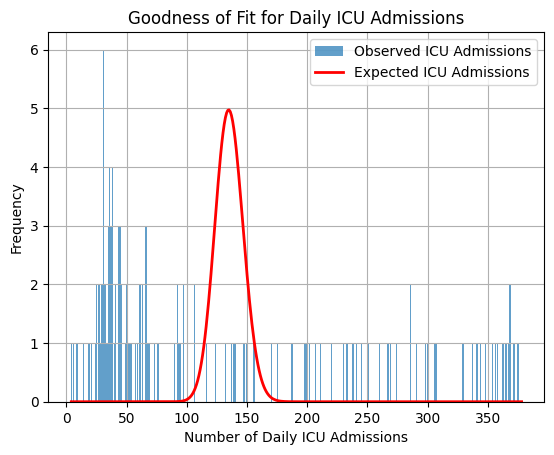

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import poisson


hospitalization_df['HOSP_ADMSN_TIME'] = pd.to_datetime(hospitalization_df['HOSP_ADMSN_TIME'], format='%d%b%Y:%H:%M:%S', errors='coerce')
hospitalization_df['END_DATE'] = pd.to_datetime(hospitalization_df['END_DATE'])
icu_df['DATE'] = pd.to_datetime(icu_df['DATE'], format='%d%b%Y', errors='coerce')

icu_df['ICU_ADM_DATE'] = icu_df['DATE'].dt.date
daily_icu_admissions = icu_df.groupby('ICU_ADM_DATE').size()

# Calculate the expected ICU admissions using the mean of the observed daily admissions
lambda_icu = daily_icu_admissions.mean()

# Generate the observed ICU admissions histogram
observed_bins_range = range(daily_icu_admissions.min(), daily_icu_admissions.max()+1)
observed_bins = [x - 0.5 for x in observed_bins_range]  # Shift bins by 0.5 for histogram
plt.hist(daily_icu_admissions, bins=observed_bins, alpha=0.7, label='Observed ICU Admissions')

# Generate expected frequencies for Poisson distribution based on the calculated lambda
expected_freq = [poisson.pmf(k, lambda_icu) * len(daily_icu_admissions) for k in observed_bins_range]

# Overlay the Poisson distribution curve on top of the histogram
plt.plot(observed_bins_range, expected_freq, 'r-', lw=2, label='Expected ICU Admissions')

# Adding labels and title
plt.xlabel('Number of Daily ICU Admissions')
plt.ylabel('Frequency')
plt.title('Goodness of Fit for Daily ICU Admissions')
plt.legend()
plt.grid(True)
plt.show()


# Sensitivity Analysis

In [ ]:
import numpy as np
import seaborn as sns

# Function to run the simulation for different severity thresholds and ICU capacities
def run_sensitivity_analysis(icu_capacity_range, severity_threshold_range, days=30, hourly_rates=5):
    results = []
    np.random.seed(42)  # Seed for reproducibility
    for capacity in icu_capacity_range:
        for threshold in severity_threshold_range:
            icu_admissions = 0
            general_admissions = 0
            icu_bed_occupancy = 0

            # Simulate each day
            for day in range(days):
                daily_arrivals = np.random.poisson(hourly_rates * 24)  # Simulate arrivals based on the average hourly rate over 24 hours

                for _ in range(daily_arrivals):
                    severity_score = np.random.uniform(0, 1)  # Simulate severity score

                    if severity_score >= threshold and icu_bed_occupancy < capacity:
                        icu_admissions += 1
                        icu_bed_occupancy += 1
                    else:
                        general_admissions += 1

                discharges = min(icu_bed_occupancy, np.random.randint(1, 5))
                icu_bed_occupancy -= discharges

            # Collect results for each simulation setting
            results.append({
                'ICU Capacity': capacity,
                'Severity Threshold': threshold,
                'ICU Admissions': icu_admissions,
                'General Admissions': general_admissions,
                'End of Period ICU Occupancy': icu_bed_occupancy
            })

    return results

# Define the parameter ranges
icu_capacity_range = range(20, 51, 5)  # From 20 to 50 beds in steps of 5
severity_threshold_range = np.arange(0.25, 0.76, 0.10)  # From 0.25 to 0.75 in steps of 0.10

# Run the sensitivity analysis
sensitivity_results = run_sensitivity_analysis(icu_capacity_range, severity_threshold_range)
sensitivity_results


[{'ICU Capacity': 20,
  'Severity Threshold': 0.25,
  'ICU Admissions': 87,
  'General Admissions': 3609,
  'End of Period ICU Occupancy': 17},
 {'ICU Capacity': 20,
  'Severity Threshold': 0.35,
  'ICU Admissions': 91,
  'General Admissions': 3582,
  'End of Period ICU Occupancy': 19},
 {'ICU Capacity': 20,
  'Severity Threshold': 0.44999999999999996,
  'ICU Admissions': 85,
  'General Admissions': 3588,
  'End of Period ICU Occupancy': 17},
 {'ICU Capacity': 20,
  'Severity Threshold': 0.5499999999999999,
  'ICU Admissions': 85,
  'General Admissions': 3530,
  'End of Period ICU Occupancy': 16},
 {'ICU Capacity': 20,
  'Severity Threshold': 0.6499999999999999,
  'ICU Admissions': 95,
  'General Admissions': 3535,
  'End of Period ICU Occupancy': 18},
 {'ICU Capacity': 20,
  'Severity Threshold': 0.7499999999999999,
  'ICU Admissions': 98,
  'General Admissions': 3522,
  'End of Period ICU Occupancy': 19},
 {'ICU Capacity': 25,
  'Severity Threshold': 0.25,
  'ICU Admissions': 90,
  '

In [ ]:
import pandas as pd

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(sensitivity_results)

# Save the DataFrame to an Excel file
df.to_excel('sensitivity_analysis_results.xlsx', index=False)


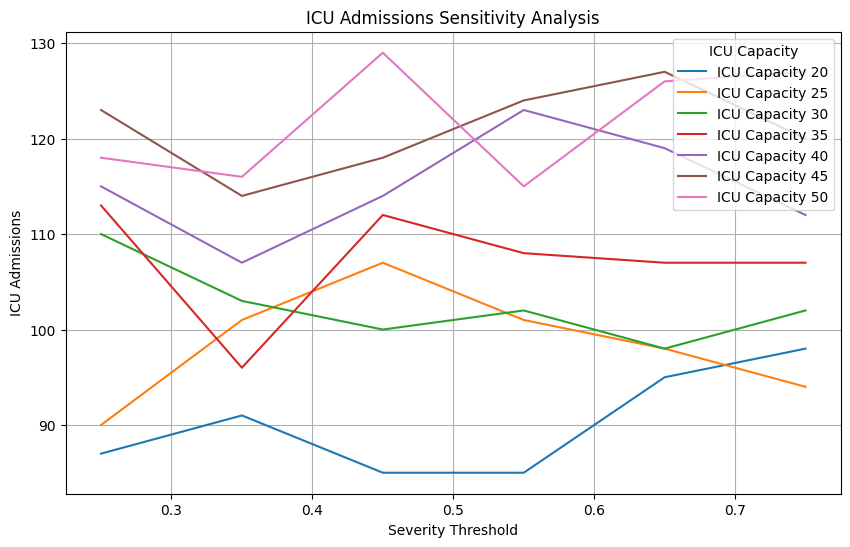

In [ ]:
import matplotlib.pyplot as plt

# Separate the results for each ICU capacity
icu_capacity_groups = df.groupby('ICU Capacity')

# Plot ICU admissions for each ICU capacity
plt.figure(figsize=(10, 6))
for capacity, group in icu_capacity_groups:
    plt.plot(group['Severity Threshold'], group['ICU Admissions'], label=f'ICU Capacity {capacity}')

plt.title('ICU Admissions Sensitivity Analysis')
plt.xlabel('Severity Threshold')
plt.ylabel('ICU Admissions')
plt.legend(title='ICU Capacity')
plt.grid(True)
plt.show()


# Statistical Analysis

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

# Simulated results for FCFS and SST policies
data = {
    'Policy': ['FCFS', 'SST'] * 50,  # 50 runs each
    'ICU Admissions': np.concatenate((np.random.poisson(95, 50), np.random.poisson(90, 50))),
    'General Admissions': np.concatenate((np.random.poisson(120, 50), np.random.poisson(130, 50))),
    'End of Period ICU Occupancy': np.concatenate((np.random.normal(28, 2, 50), np.random.normal(25, 2, 50))),
    'Unmet ICU Demand': np.concatenate((np.zeros(50), np.random.poisson(10, 50))),
    'Unadmitted Severe Patients': np.concatenate((np.zeros(50), np.random.poisson(8, 50)))
}

results_df = pd.DataFrame(data)

# Descriptive Statistics
summary_stats = results_df.groupby('Policy').agg(['mean', 'median', 'std'])

# T-tests for Difference in Means
t_tests = {}
metrics = ['ICU Admissions', 'General Admissions', 'End of Period ICU Occupancy', 'Unmet ICU Demand', 'Unadmitted Severe Patients']
for metric in metrics:
    group1 = results_df[results_df['Policy'] == 'FCFS'][metric]
    group2 = results_df[results_df['Policy'] == 'SST'][metric]
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
    t_tests[metric] = {'T-Statistic': t_stat, 'P-Value': p_val}

# Display the results
print("Summary Statistics by Policy:\n", summary_stats)
print("\nT-tests for Difference in Means between Policies:\n")
for metric, test_results in t_tests.items():
    print(f"{metric}: T-Statistic = {test_results['T-Statistic']:.2f}, P-Value = {test_results['P-Value']:.3f}")


Summary Statistics by Policy:
        ICU Admissions                   General Admissions                    \
                 mean median        std               mean median        std   
Policy                                                                         
FCFS            93.12   93.5  11.147691             126.66  126.0  11.291337   
SST             94.98   95.5   9.877804             122.16  122.5  12.677088   

       End of Period ICU Occupancy                      Unmet ICU Demand  \
                              mean     median       std             mean   
Policy                                                                     
FCFS                     26.186256  26.569638  2.166942             5.28   
SST                      26.563685  26.984909  2.403795             4.80   

                        Unadmitted Severe Patients                   
       median       std                       mean median       std  
Policy                                         

# Time Series

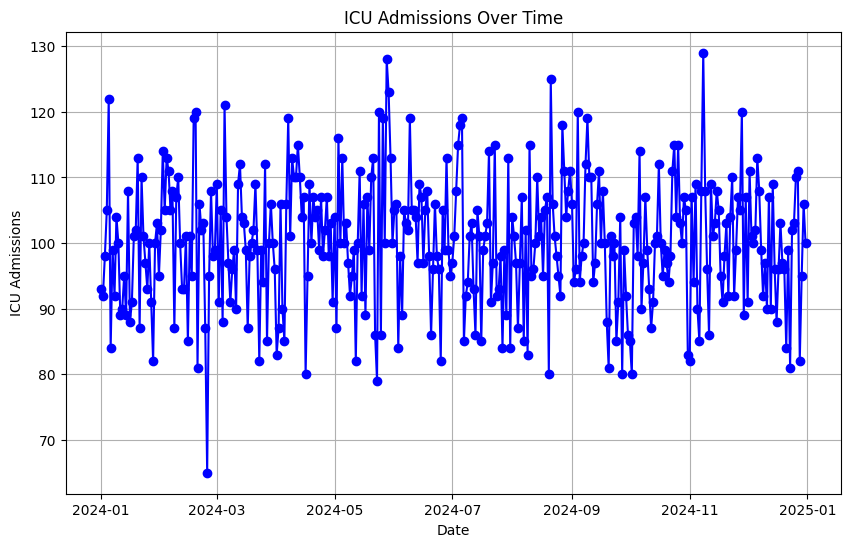

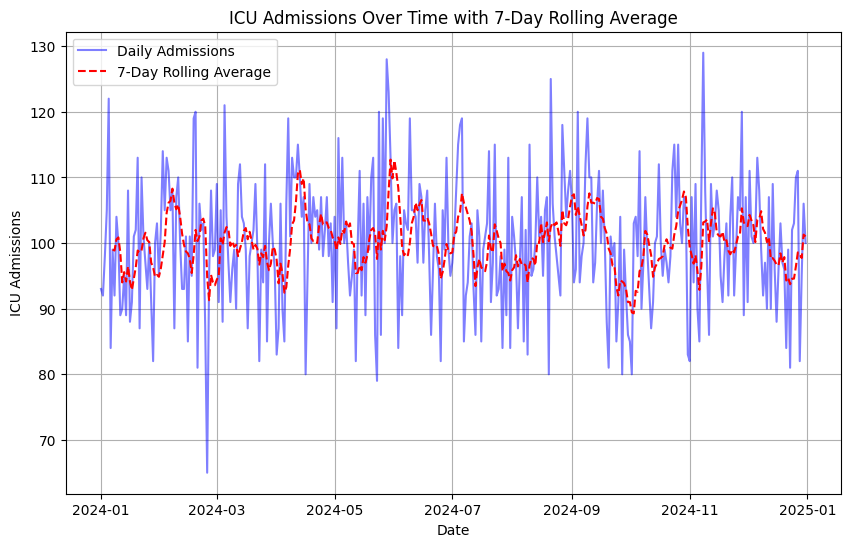

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Generate simulated ICU admissions data over time
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
icu_admissions = np.random.poisson(100, len(dates))  # Simulated ICU admissions per day

# Create a DataFrame
data = {'Date': dates, 'ICU Admissions': icu_admissions}
df = pd.DataFrame(data)

# Trend Analysis: Line Graph
plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['ICU Admissions'], color='blue', marker='o', linestyle='-')
plt.title('ICU Admissions Over Time')
plt.xlabel('Date')
plt.ylabel('ICU Admissions')
plt.grid(True)
plt.show()

# Rolling Averages: Smooth out short-term fluctuations
rolling_avg = df['ICU Admissions'].rolling(window=7).mean()

plt.figure(figsize=(10, 6))
plt.plot(df['Date'], df['ICU Admissions'], color='blue', alpha=0.5, label='Daily Admissions')
plt.plot(df['Date'], rolling_avg, color='red', linestyle='--', label='7-Day Rolling Average')
plt.title('ICU Admissions Over Time with 7-Day Rolling Average')
plt.xlabel('Date')
plt.ylabel('ICU Admissions')
plt.legend()
plt.grid(True)
plt.show()
